#### Artificial Neural Networks

Suppose that we have the following dataset:

(-1.6930476519295277,
 2.689683884193551,
 -1.121533145757048,
 1.6446470913859756)

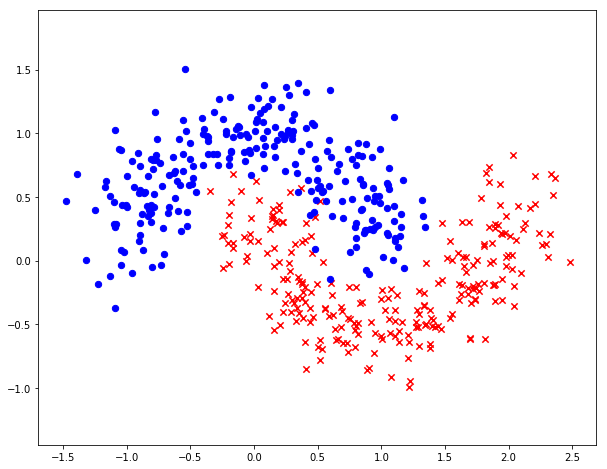

In [1]:
%matplotlib widget
%matplotlib inline
import numpy as np
from sklearn.datasets import make_circles, make_moons
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

X, y = make_moons(500, noise=0.2, random_state=42)
plt.scatter(X[:,0][y==1], X[:,1][y==1], s=40, marker='x',c='red')
plt.scatter(X[:,0][y==0], X[:,1][y==0], s=40, marker='o',c='blue')
plt.axis('equal')

In [2]:
image_folder = './images'

transformer = transforms.Compose([transforms.ToTensor()])

#train_set = datasets.MNIST(root=image_folder, train=True, transform=transformer, download=True)
#test_set = datasets.MNIST(root=image_folder, train=False, transform=transformer, download=True)

vsplit = .2
batch_size = 2
random_seed= 37
shuffle_data = True

# Creating data indices for training and validation splits:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 37, shuffle = True)

XTrainTensor = torch.tensor(xTrain, dtype=torch.float)
XTestTensor = torch.tensor(xTest, dtype=torch.float)
yTrainTensor = torch.tensor(yTrain, dtype=torch.long)
yTestTensor = torch.tensor(yTest, dtype=torch.long)

trainDataset = torch.utils.data.TensorDataset(XTrainTensor, yTrainTensor)
testDataset = torch.utils.data.TensorDataset(XTestTensor, yTestTensor)

train_loader = torch.utils.data.DataLoader(dataset=trainDataset,
                                         batch_size=batch_size,
                                         shuffle=shuffle_data)

test_loader = torch.utils.data.DataLoader(dataset=testDataset,
                                         batch_size=batch_size,
                                         shuffle=shuffle_data)

Here, $X=\{x^{(1)},x^{(2)}, \dots,x^{(m)}  \}$ and $x^{(i)} \in \mathbb{R}$ where each sample has two features. Each sample is labeled into two categories with labels $y^{(i)} \in \{0,1\}$. The ANN that we will use here is a simple 3 layer network, with 3 neurons in the input layer, 2 neurons in the hidden layer, and 1 neuron in the output layer. Suppose that we use the mean square error (MSE), as the loss function to optimize the network. Recall that the MSE is

$$ \mathcal{L}(\hat{y},y)=\frac{1}{m} \sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})^2$$

a) For this ANN, suppose that the activation function used is a tanh activation function. What is the gradient descent update for the output layer, layer 3, that is:

$$\frac{\partial\mathcal{L}}{\partial \mathbf{W}^{[\ell]}} = \text{?}$$

where $\ell = 3$.

#### Answer

Since $\hat{y}^{(i)} = a^{[3](i)}$, replace $\hat{y}^{(i)}$ in the loss equation.

$$ \mathcal{L}(\hat{y},y)=\frac{1}{m} \sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{m} \sum_{i=1}{m}(a^{[3](i)} - y^{(i)})^2$$

To find the gradient descent update, we find the gradient of $\mathcal{L}$ w.r.t. $\mathbf{W}$. This can be calculated using the chain rule.

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[3]}} = \frac{\partial \mathcal{L}}{\partial a^{[3]}}\frac{\partial a^{[3]}}{\partial z^{[3]}}\frac{\partial z^{[3]}}{\partial \mathbf{W}^{[3]}} $$

Let's find the three partial gradients one by one.

$$\frac{\partial \mathcal{L}}{\partial a^{[3]}} = \frac{2}{m} \sum_{i=0}^{m}(a^{[3](i)} - y^{(i)}) $$

$$ \frac{\partial a^{[3]}}{\partial z^{[3]}} = 1 - \tanh^2(z^{[3]}) $$

$$ \frac{\partial z^{[3]}}{\partial \mathbf{W}^{[3]}} = {a^{[2]}}^T $$

Plug these partial gradients into the original equation:

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[3]}} = \frac{2}{m} \sum_{i=0}^{m}(a^{[3](i)} - y^{(i)}) \big(1 - \tanh^2(z^{[3]})\big) {a^{[2]}}^T $$

b) Suppose now that we use the rectified linear unit, or ReLU as the activation function.

$$ReLU: f(x) = \begin{cases} 
      x & x\gt 0 \\
      0 & otherwise 
   \end{cases}
$$

Find the gradient descent update for $\ell = 3$.

#### Answer

Since we're only changing the activation function, only the part related to it will change.

$$ \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[3]}} = \begin{cases}
    \frac{2}{m} \sum_{i=0}^{m}(a^{[3](i)} - y^{(i)}) {a^{[2]}}^T & x\gt 0 \\
    0 & otherwise
    \end{cases}
$$

#### Using PyTorch

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 26)
        self.fc3 = nn.Linear(26, 2)
        
    def forward(self, x):
        x = x.view(-1, 2)
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = self.fc3(x2)
#         set_trace()
        return F.log_softmax(x3,1)
    
    def name(self):
        return "MLP"

In [4]:
model = MLP()

optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

for epoch in range(40):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(x)
        #print(out.shape)
        #print(target.shape)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
        correct_cnt+= (pred_label == target).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt*1.0/total_cnt))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
#         print(target.data)
        correct_cnt += (pred_label == target).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if(epoch+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

==>>> epoch: 0, batch index: 100, train loss: 0.554580, acc: 0.645
==>>> epoch: 0, batch index: 200, train loss: 0.525414, acc: 0.710
==>>> epoch: 0, batch index: 50, test loss: 0.487004, acc: 0.790
==>>> epoch: 1, batch index: 100, train loss: 0.489131, acc: 0.810
==>>> epoch: 1, batch index: 200, train loss: 0.450867, acc: 0.830
==>>> epoch: 1, batch index: 50, test loss: 0.317859, acc: 0.810
==>>> epoch: 2, batch index: 100, train loss: 0.327310, acc: 0.850
==>>> epoch: 2, batch index: 200, train loss: 0.295569, acc: 0.843
==>>> epoch: 2, batch index: 50, test loss: 0.519011, acc: 0.840
==>>> epoch: 3, batch index: 100, train loss: 0.379868, acc: 0.850
==>>> epoch: 3, batch index: 200, train loss: 0.307532, acc: 0.860
==>>> epoch: 3, batch index: 50, test loss: 0.289890, acc: 0.840
==>>> epoch: 4, batch index: 100, train loss: 0.250021, acc: 0.885
==>>> epoch: 4, batch index: 200, train loss: 0.261673, acc: 0.870
==>>> epoch: 4, batch index: 50, test loss: 0.380799, acc: 0.860
==>>>

In [5]:
def plot_decision_boundary(pred_func):
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    grid = np.c_[xx.ravel(),yy.ravel()]
    grid_tensor = Variable(torch.Tensor(grid))
    Z = torch.max(pred_func(grid_tensor), 1)[1].numpy()
    
    # Predict the function value for the whole gid
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.coolwarm)

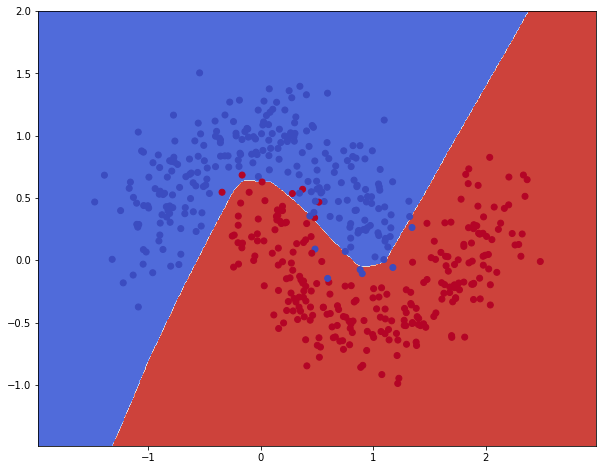

In [6]:
plot_decision_boundary(model)

#### Convolutional Neural Networks

In [7]:
import os
import imageio
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

In [8]:
def load(root):
    sub_dirs = os.listdir(root)
    testLabel = []
    testImage = []
    trainLabel = []
    trainImage = []
    
    print('Loading Data...')
    for direct in sub_dirs:
        path = os.path.join(root, direct)
        tempimg = []
        templabel = []
        for image in os.listdir(path):
            ipath = os.path.join(path, image)
            try:
                new = imageio.imread(ipath, 'png')
                templabel.append(ord(direct) - 65)
                new = new.reshape(1, 28, 28)
                tensor = transforms.ToTensor()(new).view(1,28,28).float()
                tempimg.append(np.array(tensor))
            except Exception as e:
                print(ipath + ' ' + str(e) + '. Just ignore it.')
        
        tmpTrainImg, tmpTestImg, tmpTrainLbl, tmpTestLbl = train_test_split(
            tempimg, templabel, test_size = 0.2, random_state = 7, shuffle = False)
        trainImage.extend(tmpTrainImg)
        testImage.extend(tmpTestImg)
        trainLabel.extend(tmpTrainLbl)
        testLabel.extend(tmpTestLbl)
    
    print('Training Set Size: ' + str(len(trainImage)))
    print('Testing Set Size: ' + str(len(testImage)))
    XTrainTensor = torch.tensor(trainImage, dtype=torch.float)
    XTestTensor = torch.tensor(testImage, dtype=torch.float)
    yTrainTensor = torch.tensor(trainLabel, dtype=torch.long)
    yTestTensor = torch.tensor(testLabel, dtype=torch.long)
    
    trainDataset = torch.utils.data.TensorDataset(XTrainTensor, yTrainTensor)
    testDataset = torch.utils.data.TensorDataset(XTestTensor, yTestTensor)
    
    return trainDataset, testDataset

In [9]:

batch_size = 32

trainDataset, testDataset = load('./notmnist/notMNIST_small/')

train_loader = torch.utils.data.DataLoader(dataset=trainDataset,
                                         batch_size=batch_size,
                                         shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testDataset,
                                         batch_size=batch_size,
                                         shuffle=False)

Loading Data...
./notmnist/notMNIST_small/A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png not a PNG file. Just ignore it.
./notmnist/notMNIST_small/F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png not a PNG file. Just ignore it.
Training Set Size: 14974
Testing Set Size: 3750


In [10]:
class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=2)
        self.fc1 = torch.nn.Linear(12 * 7 * 7, 256)
        self.fc2 = torch.nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.view(-1, 12 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, 1)

In [11]:
model = SimpleCNN()

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(x)
        #print(target.shape)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
        correct_cnt+= (pred_label == target).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt*1.0/total_cnt))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
#         print(target.data)
        correct_cnt += (pred_label == target).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if(epoch+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

==>>> epoch: 0, batch index: 100, train loss: 0.558774, acc: 0.698
==>>> epoch: 0, batch index: 200, train loss: 0.382920, acc: 0.786
==>>> epoch: 0, batch index: 300, train loss: 0.459812, acc: 0.821
==>>> epoch: 0, batch index: 400, train loss: 0.351645, acc: 0.839
==>>> epoch: 0, batch index: 468, train loss: 0.324870, acc: 0.849
==>>> epoch: 0, batch index: 118, test loss: 0.240392, acc: 0.891
==>>> epoch: 1, batch index: 100, train loss: 0.292658, acc: 0.920
==>>> epoch: 1, batch index: 200, train loss: 0.250001, acc: 0.916
==>>> epoch: 1, batch index: 300, train loss: 0.247789, acc: 0.917
==>>> epoch: 1, batch index: 400, train loss: 0.236120, acc: 0.919
==>>> epoch: 1, batch index: 468, train loss: 0.217234, acc: 0.921
==>>> epoch: 1, batch index: 118, test loss: 0.292563, acc: 0.914
==>>> epoch: 2, batch index: 100, train loss: 0.196125, acc: 0.943
==>>> epoch: 2, batch index: 200, train loss: 0.222030, acc: 0.938
==>>> epoch: 2, batch index: 300, train loss: 0.169078, acc: 0.9